In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
import gc

import os
import warnings
warnings.filterwarnings('ignore')

In [5]:
dtypes={
    'ip':'uint16','app':'uint16','device':'uint16','os':'uint16','channel':'uint16','ips_attributed':'uint8','click_id':'uint32'
}


In [6]:
testing = True
if testing:
    train_path = "C:/Users/tejan/OneDrive/Desktop/Click/input/train_sample.csv"
    skiprows = None
    nrows = None
    colnames=['ip','app','device','os', 'channel', 'click_time', 'is_attributed']
else:
    train_path = "C:/Users/tejan/OneDrive/Desktop/Click/input/train.csv"
    skiprows = range(1, 144903891)
    nrows = 10000000
    colnames=['ip','app','device','os', 'channel', 'click_time', 'is_attributed']

train_sample = pd.read_csv(train_path, skiprows=skiprows, nrows=nrows, dtype=dtypes, usecols=colnames)


In [7]:
len(train_sample.index)

100000

In [8]:
print(train_sample.memory_usage())

Index               128
ip               200000
app              200000
device           200000
os               200000
channel          200000
click_time       800000
is_attributed    800000
dtype: int64


In [9]:
print('Training dataset uses {0} MB'.format(train_sample.memory_usage().sum()/1024**2))

Training dataset uses 2.47967529296875 MB


In [10]:
train_sample.head()

,ip,app,device,os,channel,click_time,is_attributed
0,22004,12,1,13,497,2017-11-07 09:30:38,0
1,40024,25,1,17,259,2017-11-07 13:40:27,0
2,35888,12,1,19,212,2017-11-07 18:05:24,0
3,29048,13,1,13,477,2017-11-07 04:58:08,0
4,2877,12,1,1,178,2017-11-09 09:00:09,0


In [11]:
train_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ip             100000 non-null  uint16
 1   app            100000 non-null  uint16
 2   device         100000 non-null  uint16
 3   os             100000 non-null  uint16
 4   channel        100000 non-null  uint16
 5   click_time     100000 non-null  object
 6   is_attributed  100000 non-null  int64 
dtypes: int64(1), object(1), uint16(5)
memory usage: 2.5+ MB


In [12]:
def fraction_unique(x):
    return len(train_sample[x].unique())
number_unique_vals={x:fraction_unique(x) for x in train_sample.columns}

In [13]:
number_unique_vals

{'ip': 28470,
 'app': 161,
 'device': 100,
 'os': 130,
 'channel': 161,
 'click_time': 80350,
 'is_attributed': 2}

In [14]:
train_sample.dtypes

ip               uint16
app              uint16
device           uint16
os               uint16
channel          uint16
click_time       object
is_attributed     int64
dtype: object

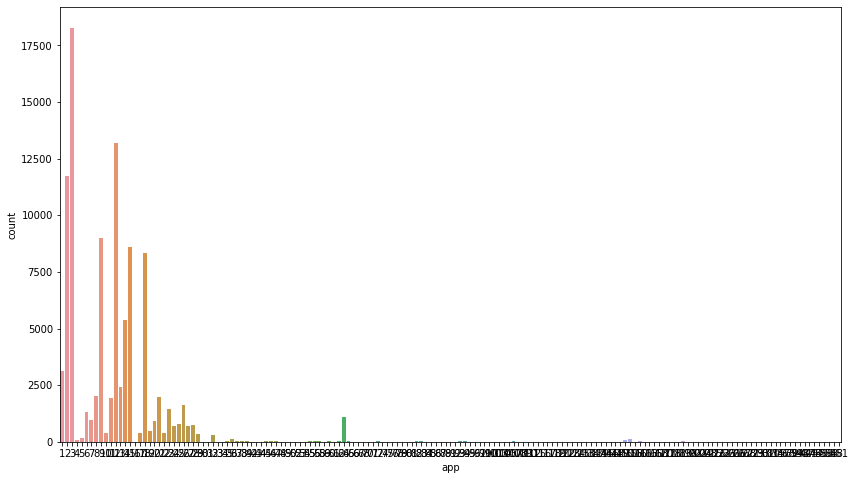

In [15]:
plt.figure(figsize=(14, 8))
sns.countplot(x="app", data=train_sample)

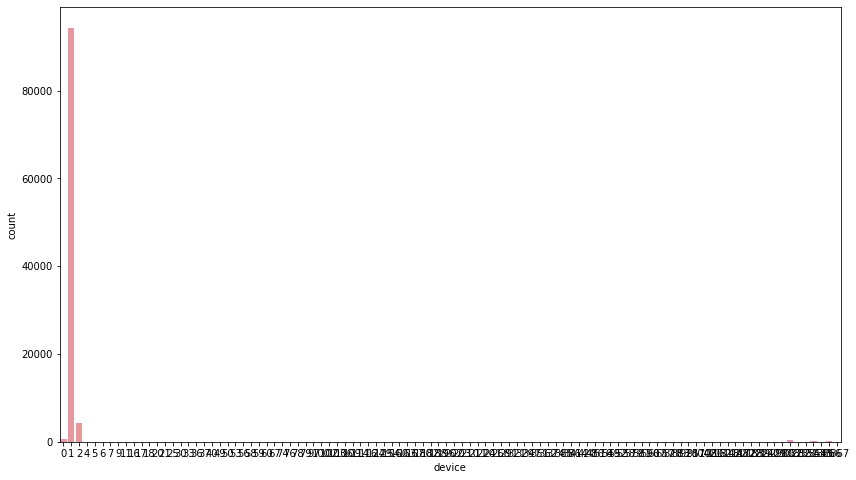

In [16]:
plt.figure(figsize=(14, 8))
sns.countplot(x="device", data=train_sample)

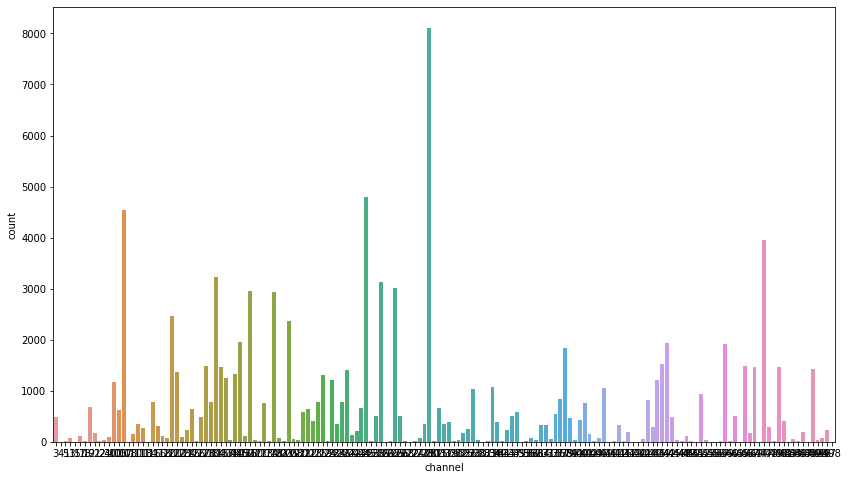

In [17]:
plt.figure(figsize=(14, 8))
sns.countplot(x="channel", data=train_sample)

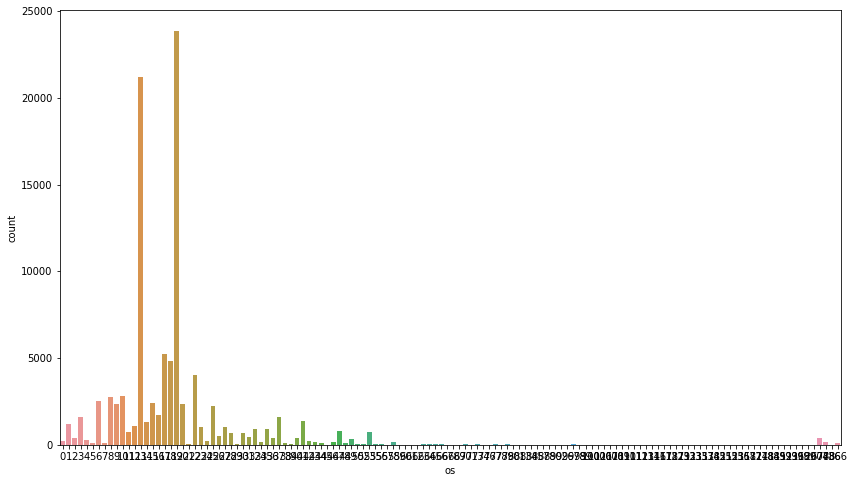

In [18]:
plt.figure(figsize=(14, 8))
sns.countplot(x="os", data=train_sample)

In [19]:
100*(train_sample['is_attributed'].astype('object').value_counts()/len(train_sample.index))

0    99.773
1     0.227
Name: is_attributed, dtype: float64

In [20]:
app_target = train_sample.groupby('app').is_attributed.agg(['mean', 'count'])
app_target

,mean,count
app,,
1,0.000000,3135
2,0.000000,11737
3,0.000219,18279
4,0.000000,58
5,0.074468,188
...,...,...
486,0.000000,1
536,0.000000,1
538,0.000000,1


In [21]:
frequent_apps=train_sample.groupby('app').size().reset_index(name='count')
frequent_apps=frequent_apps[frequent_apps['count']>frequent_apps['count'].quantile(0.80)]
frequent_apps=frequent_apps.merge(train_sample,on='app',how='inner')
frequent_apps.head()

,app,count,ip,device,os,channel,click_time,is_attributed
0,1,3135,17059,1,17,135,2017-11-09 01:17:58,0
1,1,3135,52432,1,13,115,2017-11-07 17:22:52,0
2,1,3135,23706,1,27,124,2017-11-07 09:37:21,0
3,1,3135,58458,1,19,101,2017-11-09 14:27:57,0
4,1,3135,34067,1,15,134,2017-11-07 15:06:06,0


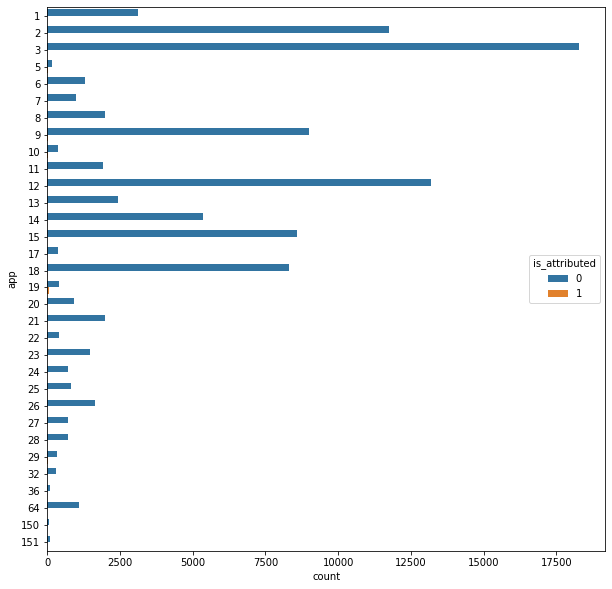

In [22]:
plt.figure(figsize=(10,10))
sns.countplot(y="app", hue="is_attributed", data=frequent_apps);

In [23]:
def time_features(df):
    df['datetime']=pd.to_datetime(df['click_time'])
    df['day_of_week']=df['datetime'].dt.dayofweek
    df['day_of_year']=df['datetime'].dt.dayofyear
    df['month']=df['datetime'].dt.month
    df['hour']=df['datetime'].dt.hour
    return df
    

In [24]:
train_sample=time_features(train_sample)
train_sample.drop(['click_time', 'datetime'], axis=1, inplace=True)
train_sample.head()

,ip,app,device,os,channel,is_attributed,day_of_week,day_of_year,month,hour
0,22004,12,1,13,497,0,1,311,11,9
1,40024,25,1,17,259,0,1,311,11,13
2,35888,12,1,19,212,0,1,311,11,18
3,29048,13,1,13,477,0,1,311,11,4
4,2877,12,1,1,178,0,3,313,11,9


In [25]:
train_sample.dtypes

ip               uint16
app              uint16
device           uint16
os               uint16
channel          uint16
is_attributed     int64
day_of_week       int64
day_of_year       int64
month             int64
hour              int64
dtype: object

In [26]:
print('Training dataset uses {0} MB'.format(train_sample.memory_usage().sum()/1024**2))

Training dataset uses 4.76849365234375 MB


In [27]:
int_vars = ['app', 'device', 'os', 'channel', 'day_of_week','day_of_year', 'month', 'hour']
train_sample[int_vars]=train_sample[int_vars].astype('uint16')

In [28]:
train_sample.dtypes

ip               uint16
app              uint16
device           uint16
os               uint16
channel          uint16
is_attributed     int64
day_of_week      uint16
day_of_year      uint16
month            uint16
hour             uint16
dtype: object

In [29]:
print('Training dataset uses {0} MB'.format(train_sample.memory_usage().sum()/1024**2))

Training dataset uses 2.47967529296875 MB


In [30]:
ip_count = train_sample.groupby('ip').size().reset_index(name='ip_count').astype('int16')
ip_count.head()

,ip,ip_count
0,8,1
1,9,1
2,10,3
3,14,1
4,16,6


In [31]:
# creates groupings of IP addresses with other features and appends the new features to the df
def grouped_features(df):
    # ip_count
    ip_count = df.groupby('ip').size().reset_index(name='ip_count').astype('uint16')
    ip_day_hour = df.groupby(['ip', 'day_of_week', 'hour']).size().reset_index(name='ip_day_hour').astype('uint16')
    ip_hour_channel = df[['ip', 'hour', 'channel']].groupby(['ip', 'hour', 'channel']).size().reset_index(name='ip_hour_channel').astype('uint16')
    ip_hour_os = df.groupby(['ip', 'hour', 'os']).channel.count().reset_index(name='ip_hour_os').astype('uint16')
    ip_hour_app = df.groupby(['ip', 'hour', 'app']).channel.count().reset_index(name='ip_hour_app').astype('uint16')
    ip_hour_device = df.groupby(['ip', 'hour', 'device']).channel.count().reset_index(name='ip_hour_device').astype('uint16')
    
    # merge the new aggregated features with the df
    df = pd.merge(df, ip_count, on='ip', how='left')
    del ip_count
    df = pd.merge(df, ip_day_hour, on=['ip', 'day_of_week', 'hour'], how='left')
    del ip_day_hour
    df = pd.merge(df, ip_hour_channel, on=['ip', 'hour', 'channel'], how='left')
    del ip_hour_channel
    df = pd.merge(df, ip_hour_os, on=['ip', 'hour', 'os'], how='left')
    del ip_hour_os
    df = pd.merge(df, ip_hour_app, on=['ip', 'hour', 'app'], how='left')
    del ip_hour_app
    df = pd.merge(df, ip_hour_device, on=['ip', 'hour', 'device'], how='left')
    del ip_hour_device
    
    return df

In [32]:
train_sample = grouped_features(train_sample)
train_sample.head()

,ip,app,device,os,channel,is_attributed,day_of_week,day_of_year,month,hour,ip_count,ip_day_hour,ip_hour_channel,ip_hour_os,ip_hour_app,ip_hour_device
0,22004,12,1,13,497,0,1,311,11,9,8,1,1,1,1,1
1,40024,25,1,17,259,0,1,311,11,13,149,4,1,1,1,8
2,35888,12,1,19,212,0,1,311,11,18,2,1,1,1,1,1
3,29048,13,1,13,477,0,1,311,11,4,3,1,1,1,1,1
4,2877,12,1,1,178,0,3,313,11,9,4,1,1,1,1,1


In [33]:
gc.collect()

8395

In [34]:
X = train_sample.drop('is_attributed', axis=1)
y = train_sample[['is_attributed']]

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(80000, 15)
(80000, 1)
(20000, 15)
(20000, 1)


In [36]:
print(y_train.mean())
print(y_test.mean())

is_attributed    0.002275
dtype: float64
is_attributed    0.00225
dtype: float64


# Extra Tree Classifier with AdaBoost Classifier

In [37]:
tree = ExtraTreesClassifier(n_estimators=100, random_state=0)

adaboost_model_1=AdaBoostClassifier(
    base_estimator=tree,
    n_estimators=600,
    learning_rate=1.54,
    algorithm="SAMME")

In [38]:
adaboost_model_1.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=ExtraTreesClassifier(bootstrap=False,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weigh

In [39]:
predictions=adaboost_model_1.predict_proba(X_test)
predictions[:10]

array([[0.73105858, 0.26894142],
       [0.73105858, 0.26894142],
       [0.73105858, 0.26894142],
       [0.73105858, 0.26894142],
       [0.73105858, 0.26894142],
       [0.73105858, 0.26894142],
       [0.73105858, 0.26894142],
       [0.73105858, 0.26894142],
       [0.73105858, 0.26894142],
       [0.73105858, 0.26894142]])

In [40]:
Extra_acc = metrics.roc_auc_score(y_test,predictions[:,1])
Extra_acc

0.5110359419805673

In [41]:
param_grid={"base_estimator__max_depth":[2,5],
           "n_estimators":[200,400,600]
           }

# Decision Tree With AdaBoost Classifier and Kfolds = 3

In [42]:
tree1 = DecisionTreeClassifier()
ABC=AdaBoostClassifier(
    base_estimator=tree1,
    learning_rate=0.6,
    algorithm="SAMME")

In [43]:
folds=3
grid_search_ABC=GridSearchCV(ABC,
                            cv=folds,
                            param_grid=param_grid,
                            scoring='roc_auc',
                            return_train_score=True,
                            verbose=1)

In [44]:
grid_search_ABC.fit(X_train,y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 11.7min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME',
                                          base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                class_weight=None,
                                                                                criterion='gini',
                                                                                max_depth=None,
                                                                                max_features=None,
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_leaf=1,
   

In [45]:
predictions=grid_search_ABC.predict_proba(X_test)
predictions[:10]
DT_acc = metrics.roc_auc_score(y_test,predictions[:,1])
DT_acc

0.960727748545338

In [46]:
cv_results = pd.DataFrame(grid_search_ABC.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_base_estimator__max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,13.760688,0.438581,0.583647,0.038732,2,200,"{'base_estimator__max_depth': 2, 'n_estimators...",0.926966,0.975725,0.955801,0.952831,0.020017,1,0.996306,0.995094,0.996461,0.995954,0.000611
1,24.907065,0.505402,1.051683,0.011552,2,400,"{'base_estimator__max_depth': 2, 'n_estimators...",0.920643,0.974585,0.956496,0.950575,0.022416,2,0.997991,0.996683,0.997996,0.997556,0.000618
2,37.233534,0.802382,1.562008,0.010770,2,600,"{'base_estimator__max_depth': 2, 'n_estimators...",0.921720,0.973335,0.953955,0.949670,0.021288,3,0.998494,0.997923,0.998417,0.998278,0.000253
3,25.059003,1.958381,0.594761,0.081301,5,200,"{'base_estimator__max_depth': 5, 'n_estimators...",0.904266,0.939887,0.942041,0.928732,0.017322,4,1.000000,1.000000,1.000000,1.000000,0.000000
4,48.198591,2.665386,1.013642,0.013123,5,400,"{'base_estimator__max_depth': 5, 'n_estimators...",0.900079,0.940118,0.935517,0.925238,0.017889,5,1.000000,1.000000,1.000000,1.000000,0.000000
5,66.617568,0.252457,1.494016,0.002921,5,600,"{'base_estimator__max_depth': 5, 'n_estimators...",0.886150,0.925682,0.937793,0.916542,0.022052,6,1.000000,1.000000,1.000000,1.000000,0.000000


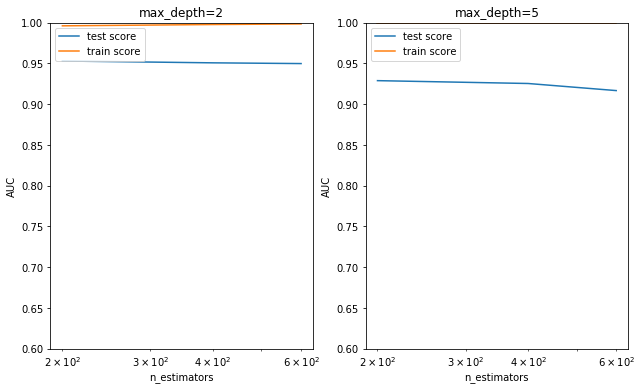

In [47]:
# plotting AUC with hyperparameter combinations

plt.figure(figsize=(16,6))
for n, depth in enumerate(param_grid['base_estimator__max_depth']):
    

    # subplot 1/n
    plt.subplot(1,3, n+1)
    depth_df = cv_results[cv_results['param_base_estimator__max_depth']==depth]

    plt.plot(depth_df["param_n_estimators"], depth_df["mean_test_score"])
    plt.plot(depth_df["param_n_estimators"], depth_df["mean_train_score"])
    plt.xlabel('n_estimators')
    plt.ylabel('AUC')
    plt.title("max_depth={0}".format(depth))
    plt.ylim([0.60, 1])
    plt.legend(['test score', 'train score'], loc='upper left')
    plt.xscale('log')

    


# Random Forest Classifier

In [49]:
RFC = RandomForestClassifier(max_depth=2, random_state=0)

In [50]:
RFC.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [51]:
predictions = RFC.predict_proba(X_test)
predictions[:10]
RF_acc = metrics.roc_auc_score(y_test,predictions[:,1])
RF_acc

0.9362170439043404

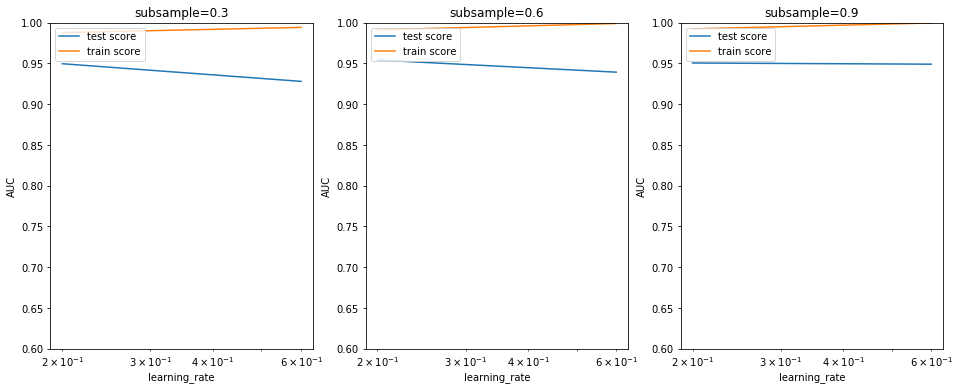

In [83]:
plt.figure(figsize=(16,6))


for n, subsample in enumerate(param_grid['subsample']):
    

    # subplot 1/n
    plt.subplot(1,len(param_grid['subsample']), n+1)
    df = cv_results[cv_results['param_subsample']==subsample]

    plt.plot(df["param_learning_rate"], df["mean_test_score"])
    plt.plot(df["param_learning_rate"], df["mean_train_score"])
    plt.xlabel('learning_rate')
    plt.ylabel('AUC')
    plt.title("subsample={0}".format(subsample))
    plt.ylim([0.60, 1])
    plt.legend(['test score', 'train score'], loc='upper left')
    plt.xscale('log')


# XGB Classifier

In [61]:
model = XGBClassifier()
model.fit(X_train, y_train)

[18:50:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, objective='binary:logistic',
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=True, validate_parameters=1, verbosity=None)

In [62]:
y_pred = model.predict_proba(X_test)
y_pred[:10]

array([[9.9999809e-01, 1.9337567e-06],
       [9.9998653e-01, 1.3449854e-05],
       [9.9997407e-01, 2.5916344e-05],
       [9.9952990e-01, 4.7011764e-04],
       [9.9978644e-01, 2.1357677e-04],
       [9.9999368e-01, 6.3347384e-06],
       [9.9991673e-01, 8.3290950e-05],
       [9.9998868e-01, 1.1305605e-05],
       [9.9981380e-01, 1.8618918e-04],
       [9.9910051e-01, 8.9947641e-04]], dtype=float32)

In [63]:
xgb_acc = metrics.roc_auc_score(y_test, y_pred[:, 1])
print("AUC: %.2f%%" % (xgb_acc * 100.0))

AUC: 96.06%


# XGbooster with Kfolds

In [64]:
folds = 3

# specify range of hyperparameters
param_grid = {'learning_rate': [0.2, 0.6], 
             'subsample': [0.3, 0.6, 0.9]}          


# specify model
xgb_model = XGBClassifier(max_depth=2, n_estimators=200)

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      



In [65]:
model_cv.fit(X_train, y_train)       

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[18:50:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[18:50:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:51:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:51:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:51:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  1.1min finished


[18:51:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=2, min_child_weight=None,
                                     missing=nan, monotone_cons...
                                     predictor=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, use_label_

In [66]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,3.294663,0.057990,0.041669,0.000473,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.914064,0.971373,0.962963,0.949467,0.025268,3,0.990450,0.984303,0.988183,0.987645,0.002538
1,3.622332,0.112206,0.043001,0.001633,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.926961,0.973582,0.961443,0.953995,0.019748,1,0.994016,0.986355,0.992693,0.991021,0.003343
2,3.362666,0.030025,0.042335,0.001885,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.924236,0.975867,0.951012,0.950372,0.021083,2,0.992880,0.989807,0.993936,0.992208,0.001752
3,3.501997,0.314354,0.041341,0.000481,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",0.885865,0.957231,0.940434,0.927843,0.030465,6,0.997522,0.991143,0.993425,0.994030,0.002639
4,3.938997,0.255233,0.039002,0.001416,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",0.893749,0.967978,0.955700,0.939142,0.032487,5,0.999624,0.997823,0.998964,0.998804,0.000744
5,3.419665,0.159468,0.042004,0.000002,0.6,0.9,"{'learning_rate': 0.6, 'subsample': 0.9}",0.923785,0.975658,0.947313,0.948919,0.021207,4,0.999633,0.999070,0.999660,0.999454,0.000272


In [67]:

cv_results['param_learning_rate'] = cv_results['param_learning_rate'].astype('float')
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,3.294663,0.057990,0.041669,0.000473,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.914064,0.971373,0.962963,0.949467,0.025268,3,0.990450,0.984303,0.988183,0.987645,0.002538
1,3.622332,0.112206,0.043001,0.001633,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.926961,0.973582,0.961443,0.953995,0.019748,1,0.994016,0.986355,0.992693,0.991021,0.003343
2,3.362666,0.030025,0.042335,0.001885,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.924236,0.975867,0.951012,0.950372,0.021083,2,0.992880,0.989807,0.993936,0.992208,0.001752
3,3.501997,0.314354,0.041341,0.000481,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",0.885865,0.957231,0.940434,0.927843,0.030465,6,0.997522,0.991143,0.993425,0.994030,0.002639
4,3.938997,0.255233,0.039002,0.001416,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",0.893749,0.967978,0.955700,0.939142,0.032487,5,0.999624,0.997823,0.998964,0.998804,0.000744


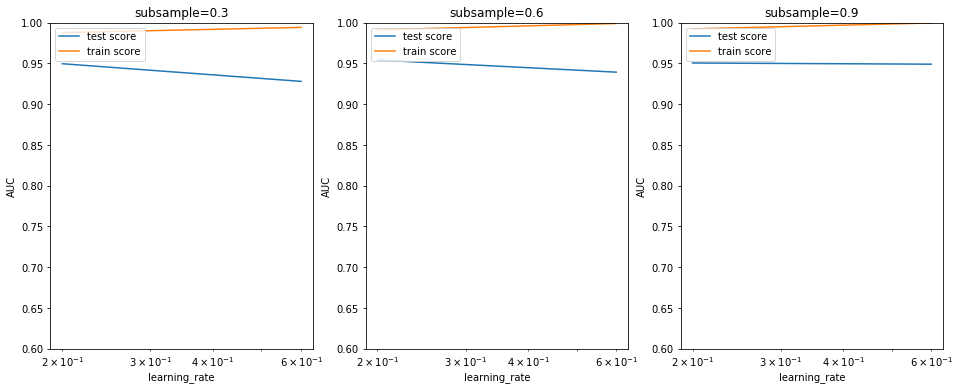

In [68]:
plt.figure(figsize=(16,6))

param_grid = {'learning_rate': [0.2, 0.6], 
             'subsample': [0.3, 0.6, 0.9]} 


for n, subsample in enumerate(param_grid['subsample']):
    

    # subplot 1/n
    plt.subplot(1,len(param_grid['subsample']), n+1)
    df = cv_results[cv_results['param_subsample']==subsample]

    plt.plot(df["param_learning_rate"], df["mean_test_score"])
    plt.plot(df["param_learning_rate"], df["mean_train_score"])
    plt.xlabel('learning_rate')
    plt.ylabel('AUC')
    plt.title("subsample={0}".format(subsample))
    plt.ylim([0.60, 1])
    plt.legend(['test score', 'train score'], loc='upper left')
    plt.xscale('log')

# Naive Bayes

In [70]:
from sklearn.naive_bayes import GaussianNB
GNb = GaussianNB()
GNb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [72]:
predictions=GNb.predict_proba(X_test)
predictions[:10]
GB_acc = metrics.roc_auc_score(y_test,predictions[:,1])
GB_acc

0.7821966090369998

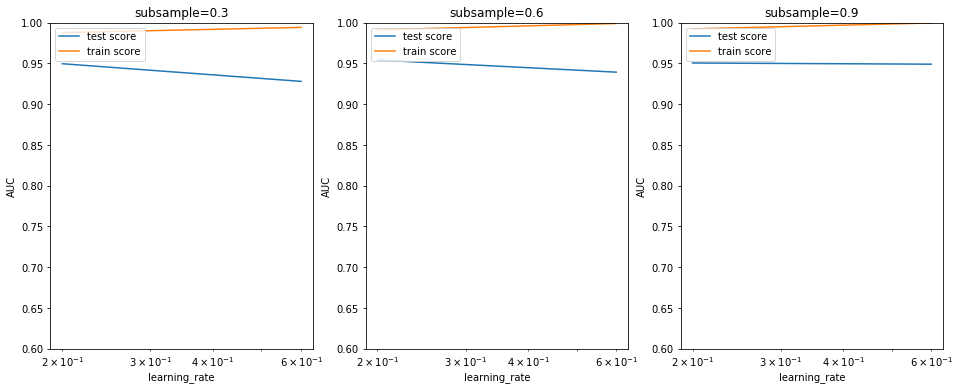

In [77]:
plt.figure(figsize=(16,6))


for n, subsample in enumerate(param_grid['subsample']):
    

    # subplot 1/n
    plt.subplot(1,len(param_grid['subsample']), n+1)
    df = cv_results[cv_results['param_subsample']==subsample]

    plt.plot(df["param_learning_rate"], df["mean_test_score"])
    plt.plot(df["param_learning_rate"], df["mean_train_score"])
    plt.xlabel('learning_rate')
    plt.ylabel('AUC')
    plt.title("subsample={0}".format(subsample))
    plt.ylim([0.60, 1])
    plt.legend(['test score', 'train score'], loc='upper left')
    plt.xscale('log')

# Accuracy Comparsion

In [78]:
score = [Extra_acc,DT_acc,RF_acc,xgb_acc,GB_acc]

In [79]:
#make variabel for save the result and to show it
classifier = ('Extra Tree Classifier with Gradiant Boosting','Decision Tree with Gradiant Boosting','Random Forest','XGBoost Classifier','Naive Bayes')
y_pos = np.arange(len(classifier))
print(y_pos)
print(score)

[0 1 2 3 4]
[0.5110359419805673, 0.960727748545338, 0.9362170439043404, 0.9606303070798186, 0.7821966090369998]


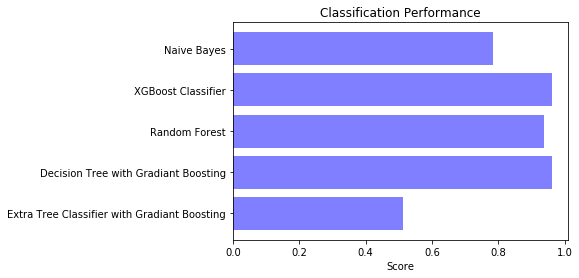

In [80]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, score, align='center', alpha=0.5,color='blue')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Score')
plt2.title('Classification Performance')
plt2.show()

# Model Building

In [81]:
import joblib
filename = 'model.sav'
joblib.dump(model, filename)

['model.sav']